In [61]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

labels_names = ['NonDementia', 'VeryMildDementia', 'MildDementia', 'ModerateDementia']

import numpy as np
from scipy.ndimage import binary_opening, binary_dilation
from skimage import filters
from scipy.ndimage import distance_transform_edt
from skimage import morphology
from skimage import segmentation

def skull_strip_axial_brain(axial_brain):

    if len(axial_brain.shape) == 3:
        axial_brain = np.mean(axial_brain, axis=-1)

    # Otsu thresholding
    threshold = filters.threshold_otsu(axial_brain)
    brain_mask = (axial_brain > 0.8*threshold).astype(np.uint8)

    # Morphological Operations
    se = 4  

    brain_mask = binary_opening(brain_mask, structure=np.ones((se, se)))
    brain_mask = binary_dilation(brain_mask, structure=np.ones((2, 2)))

    skull_stripped = axial_brain * brain_mask

    return skull_stripped, brain_mask

def watershed_segmentation(image, brain_mask):
    
    distance = distance_transform_edt(brain_mask)    

    local_max = morphology.local_maxima(distance, indices=False, footprint=np.ones((3, 3)))
    markers = morphology.label(local_max)
    labels = segmentation.watershed(-distance, markers, mask=brain_mask)

    segmented = image * brain_mask

    return segmented, labels


def preprocess_alzheimer(image):

    axial_brain = np.array(image)
    skull_stripped_image, brain_mask = skull_strip_axial_brain(axial_brain)
    segmented, labels = watershed_segmentation(skull_stripped_image, brain_mask)

    return axial_brain, brain_mask, skull_stripped_image, segmented, labels


def load_and_preprocess_random_subset(directory, image_size, subset_size=1000):

    image_paths = []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                file_path = os.path.join(label_path, filename)
                if file_path.endswith(('.jpg')):
                    image_paths.append(file_path)

    np.random.shuffle(image_paths)

    selected_paths = image_paths[:subset_size]

    original_images = []
    brain_masks = []
    skull_stripped_images = []
    segmented_images = []
    labels = []

    for file_path in selected_paths:
        original_image = Image.open(file_path).resize(image_size)

        axial_brain, brain_mask, skull_stripped_image, segmented, label = preprocess_alzheimer(original_image)
        original_images.append(axial_brain)
        brain_masks.append(brain_mask)
        skull_stripped_images.append(skull_stripped_image)
        segmented_images.append(segmented)
        labels.append(label)

    return original_images, brain_masks, skull_stripped_images, segmented_images, labels

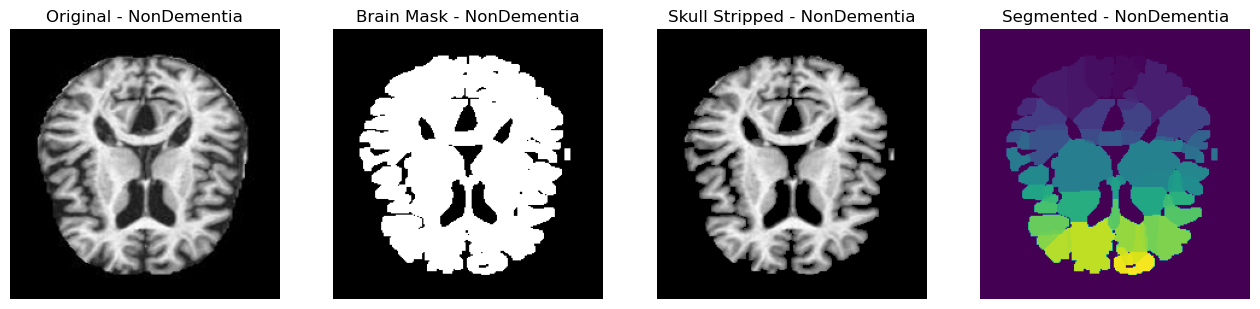

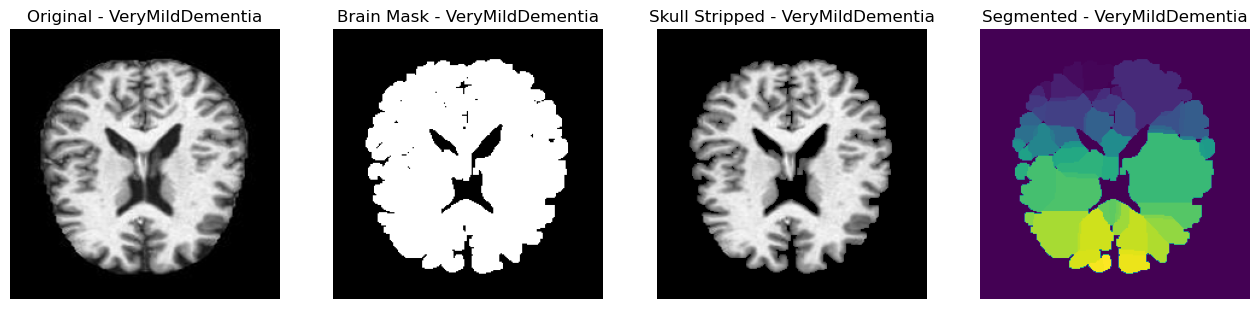

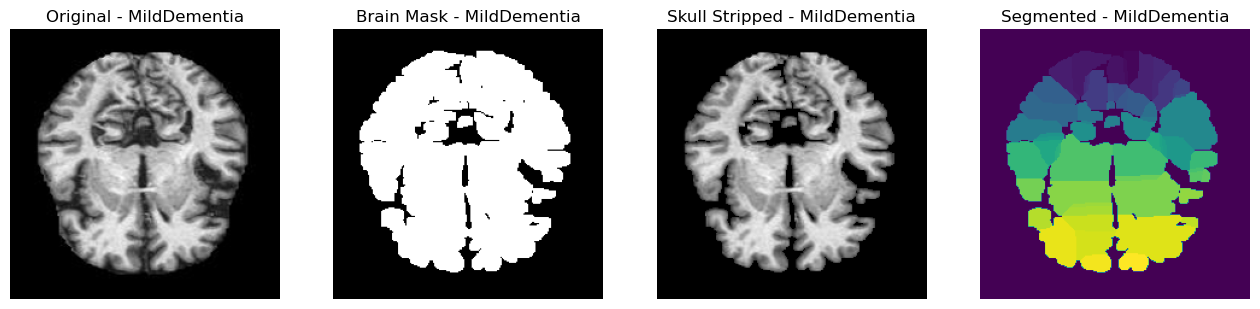

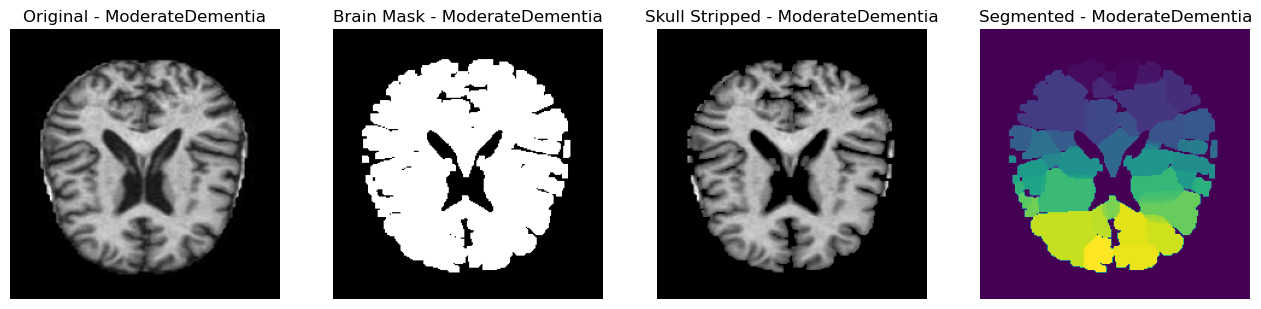

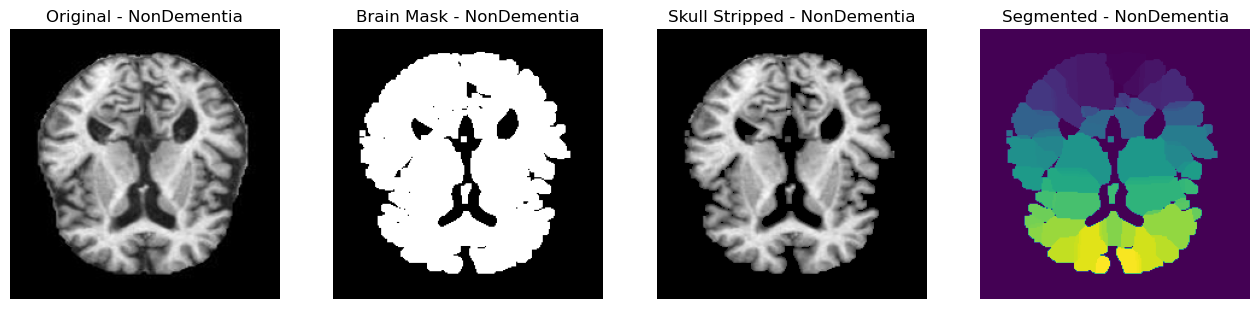

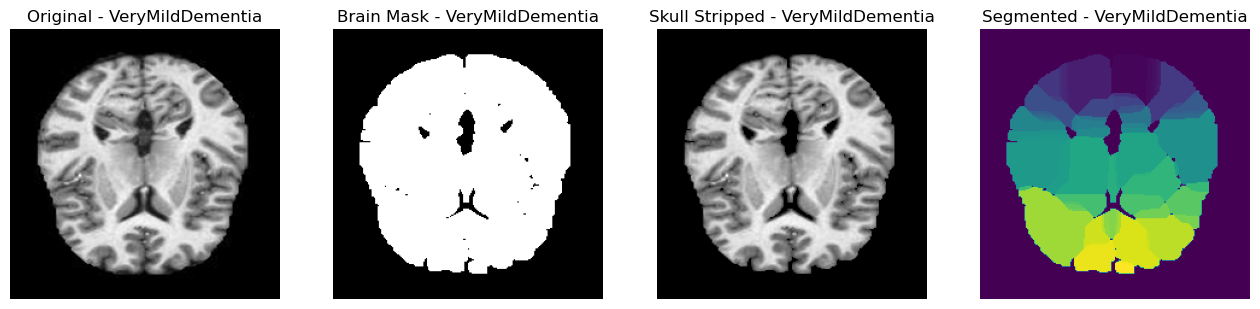

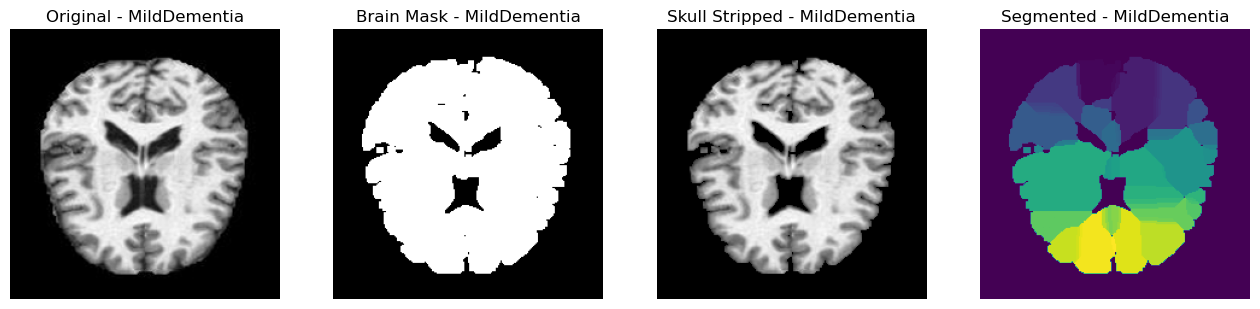

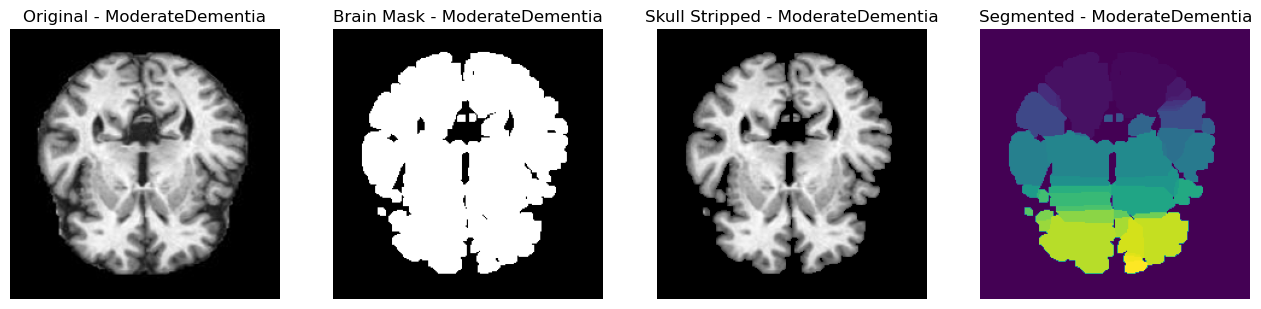

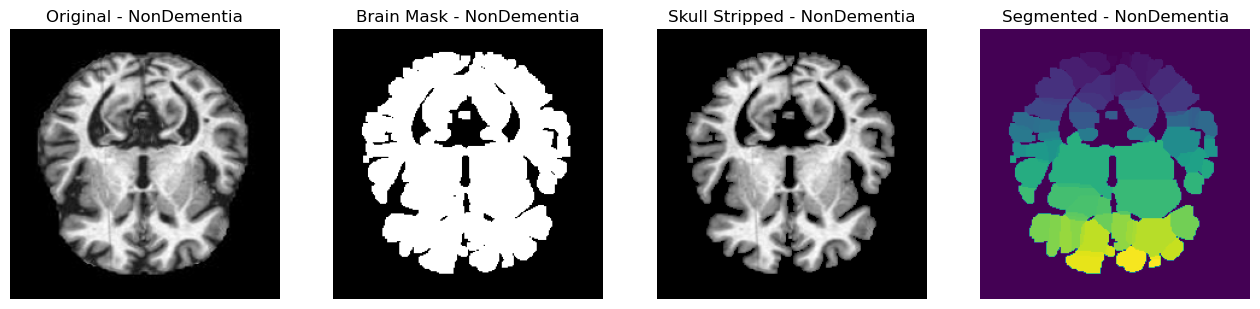

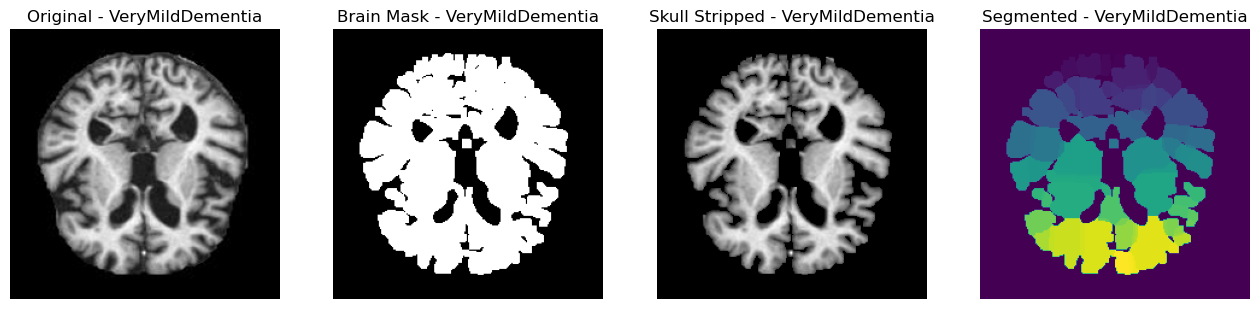

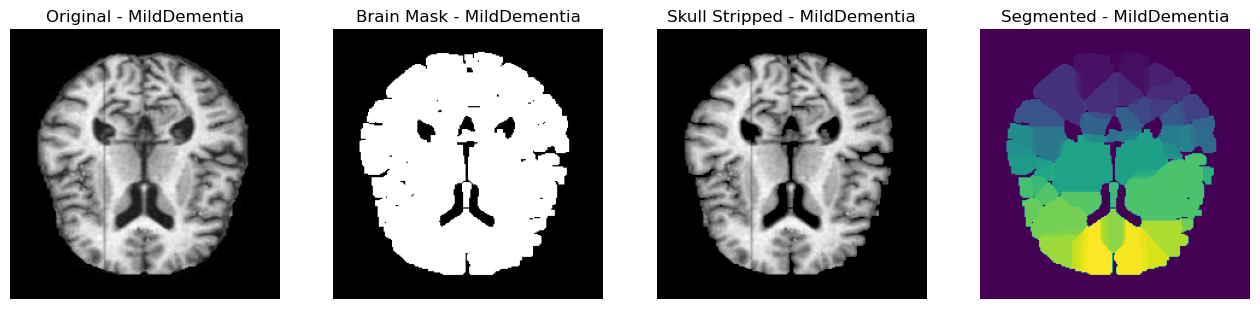

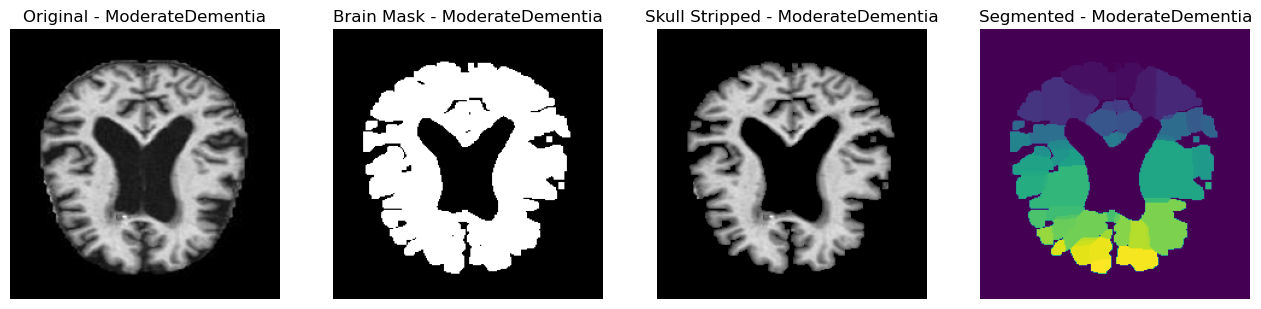

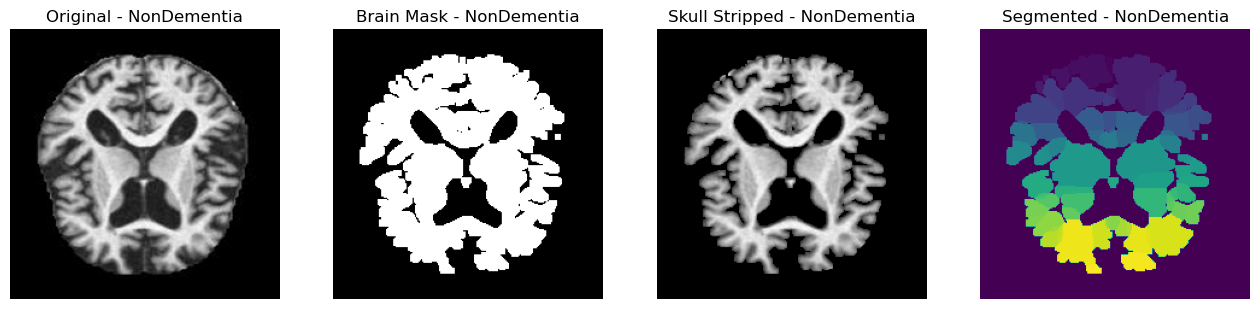

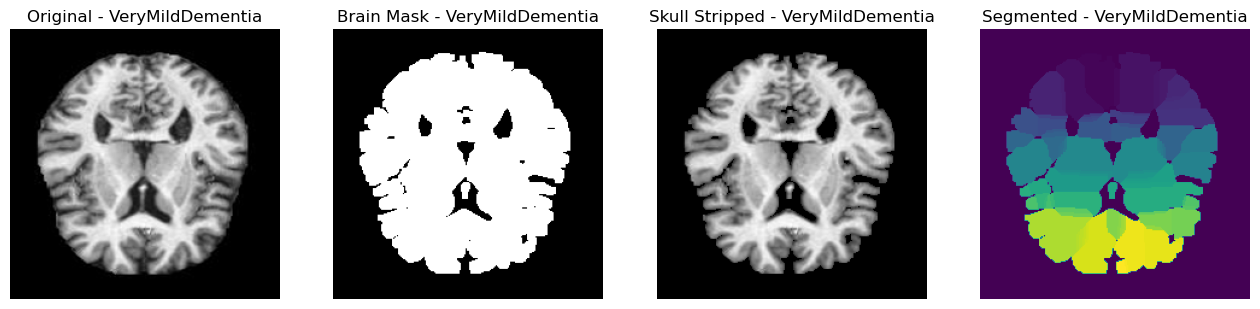

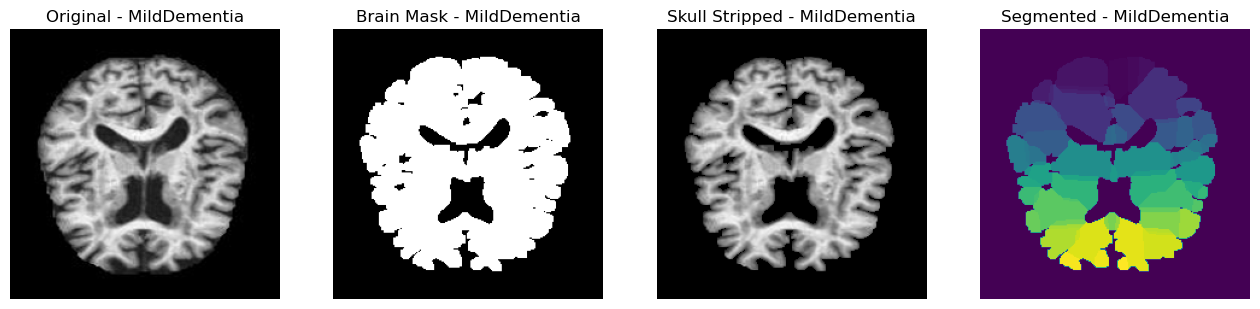

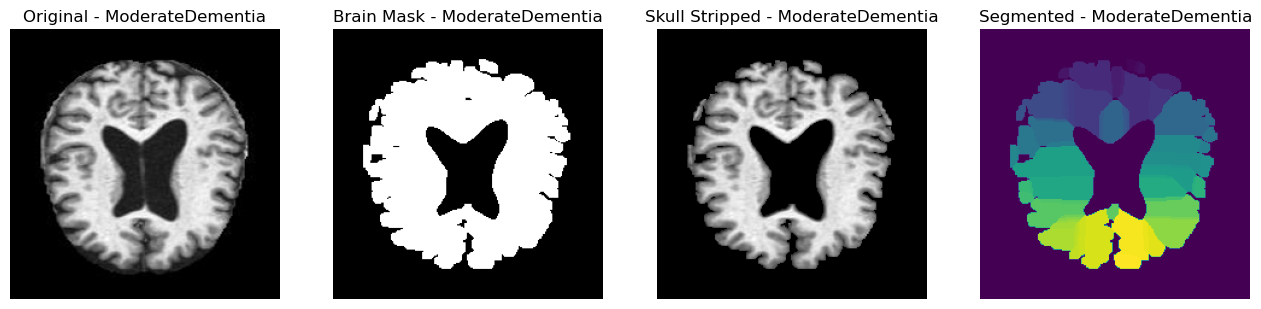

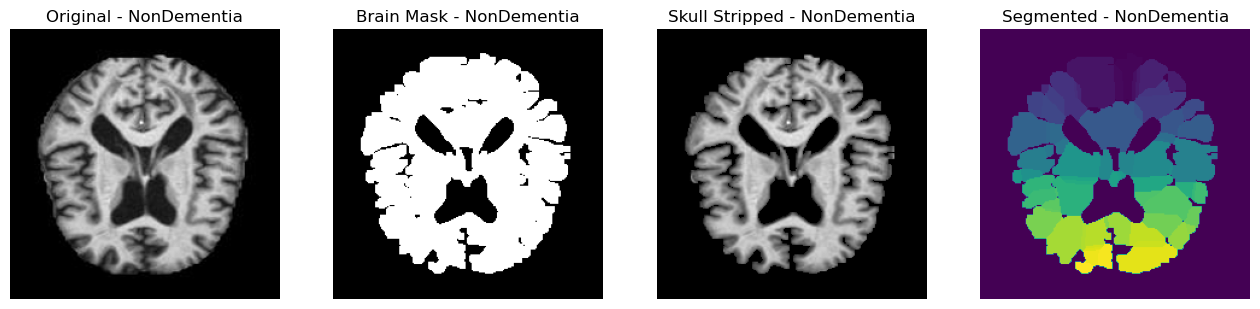

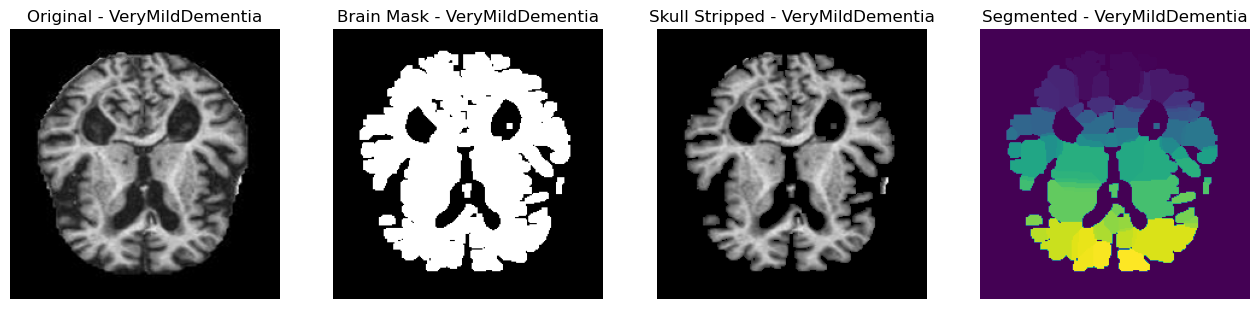

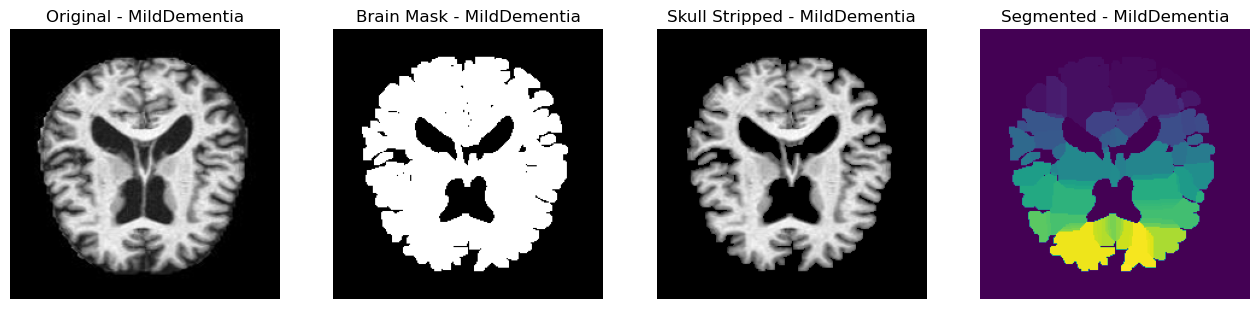

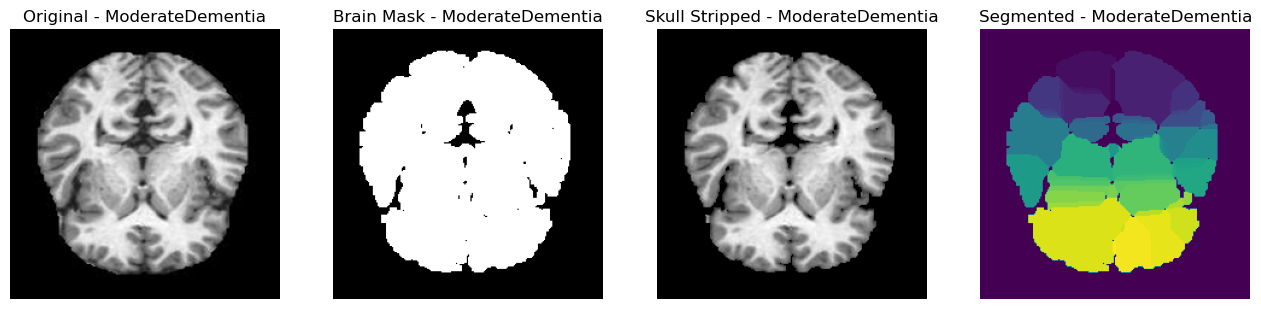

In [62]:
input_directory = "/Users/annafernandezrajal/Downloads/Alzheimer_s Dataset/train"
output_directory = "preprocessed_images"
image_size = (224, 224)
subset_size = 20

original_images, brain_masks, skull_stripped_images, segmented_images, labels = load_and_preprocess_random_subset(input_directory, image_size, subset_size)

for i in range(subset_size):
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 4, 1)
    plt.imshow(np.array(original_images[i]), cmap='gray')
    plt.title(f'Original - {labels_names[i % len(labels_names)]}')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(np.array(brain_masks[i]), cmap='gray')
    plt.title(f'Brain Mask - {labels_names[i % len(labels_names)]}')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(np.array(skull_stripped_images[i]), cmap='gray')
    plt.title(f'Skull Stripped - {labels_names[i % len(labels_names)]}')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(np.array(labels[i]))
    plt.title(f'Segmented - {labels_names[i % len(labels_names)]}')
    plt.axis('off')

    plt.show()
